In [1]:
import torch
import torch.nn as nn
import math
import numpy as np
import random
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
#import spacy
from torchtext.legacy.data import Field, BucketIterator
from sklearn.model_selection import train_test_split
from torchtext.vocab import build_vocab_from_iterator
import re
from transformers import BertTokenizer

In [2]:
from dataloader import *
from transformer import *

# Model definition

In [3]:
class TransformerClassifier(torch.nn.Module):

    def __init__(self, src_pad_idx, enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device):
        super(TransformerClassifier, self).__init__()

        self.src_pad_idx = src_pad_idx
        self.encoder = Encoder(enc_voc_size, max_len, d_model, ffn_hidden, n_head, n_layers, drop_prob, device)
        self.linear = nn.Linear(d_model * max_len, 2).to(device)

    def make_pad_mask(self, q, k):
        len_q, len_k = q.size(1), k.size(1)

        # batch_size x 1 x 1 x len_k
        k = k.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        # batch_size x 1 x len_q x len_k
        k = k.repeat(1, 1, len_q, 1)

        # batch_size x 1 x len_q x 1
        q = q.ne(self.src_pad_idx).unsqueeze(1).unsqueeze(3)
        # batch_size x 1 x len_q x len_k
        q = q.repeat(1, 1, 1, len_k)

        mask = k & q
        return mask

    def forward(self, x):
        mask = self.make_pad_mask(x, x)
        x = self.encoder(x, mask)
        x = x.view(x.shape[0], -1)
        x = self.linear(x)
        return x

In [4]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.kaiming_uniform(m.weight.data)

In [5]:
def plot_training(history, marker=None):
  plt.subplots_adjust(left=0.1,
                    bottom=0.01,
                    right=1.5,
                    top=0.6,
                    wspace=0.4,
                    hspace=0.4)

  plt.subplot(1, 2, 1)
  plt.plot(history['train_loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title('Training loss')

  # vertical line for marking best epoch
  if marker is not None:
    y_min = min(history['train_loss'] + history['val_loss'])
    y_max = max(history['train_loss'] + history['val_loss'])
    plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

  plt.subplot(1, 2, 2)
  plt.plot(history['train_acc'])
  plt.plot(history['val_acc'])
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.title('Training metric')

  # vertical line for marking best epoch
  if marker is not None:
    y_min = min(history['train_acc'] + history['val_acc'])
    y_max = max(history['train_acc'] + history['val_acc'])
    plt.vlines(x=marker, ymin=y_min, ymax=y_max, color='red')

  plt.show()

In [6]:
def validation(model, iterator, optimizer, criterion, device):
    # set model into evaluation mode
    model.eval()

    # validation
    # loss, metrics for current epoch
    val_epoch_loss = 0
    val_epoch_accuracy = 0

    with torch.no_grad(): # stop graph
        # batches
        for i, batch in enumerate(iterator):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            output = model(src)
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)

            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy

            val_epoch_loss += loss.item()
            val_epoch_accuracy += accuracy

    # return mean loss w.r.t. batches
    return val_epoch_loss / len(iterator), val_epoch_accuracy / len(iterator)

def train(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history)

    return history

def train_save_best(model, iterator, optimizer, criterion, epoch, clip, device):
    # set model into training mode
    model.train()

    # save data - init
    history = {'train_loss': [],
               'val_loss': [],
               'train_acc': [],
               'val_acc': []}
    best_model = None
    best_model_score = 1e9
    best_model_epoch = 0

    # training
    for e in range(epoch):
        # loss, metrics for current epoch
        epoch_loss = 0
        epoch_acc = 0

        # batches
        for i, batch in enumerate(tqdm(iterator)):
            src = batch[0] # X
            trg = batch[1] # y
            src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
            optimizer.zero_grad() # reset optimizer
            output = model(src) # predict
            y_pred = torch.argmax(output, dim=-1) # logits -> labels
            output_reshape = output.contiguous().view(-1, output.shape[-1])
            trg = trg.to(torch.int64)
            loss = criterion(output_reshape, trg) # calculate loss
            agreements = torch.eq(y_pred, trg)
            accuracy = torch.mean(agreements.double()) # calculate accuracy
            loss.backward() # backward pass

            epoch_loss += loss.item()
            epoch_acc += accuracy / len(iterator)

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step() # optimize model

        # validation
        val_loss, val_acc = validation(model, valid_iter, optimizer, criterion, device)

        # save data
        with torch.no_grad():
          for key, value in zip(history.keys(), [epoch_loss / len(iterator), val_loss, epoch_acc, val_acc]):
            history[key].append(value)

          # save best model (w.r.t validation loss)
          if val_loss < best_model_score:
            best_model = model.state_dict()
            best_model_score = val_loss
            best_model_epoch = e

        # visualization
        print(f"Epoch: {e + 1}  Train Loss: {epoch_loss / len(iterator):.4f} \
              Validation Loss: {val_loss:.4f} \
              Train acc: {epoch_acc:.4f}, \
              Val acc: {val_acc:.4f}")

    # print training curve
    plot_training(history, marker=best_model_epoch)

    return history, best_model, best_model_score

# Import data

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
# init
tokenizer = Tokenizer()
loader = DataLoader(tokenize = tokenizer.tokenize)

# import data (combine train/test as we split afterwards anyways)
data = pd.concat([pd.read_csv("./Data/SMS_train.csv", encoding='ISO-8859-1'),
                  pd.read_csv("./Data/SMS_test.csv", encoding='ISO-8859-1')])

# convert string label to binary (int) label (spam:1, non-spam:0)
labels = pd.Series((data['Label'] == 'Spam').astype(int))
data['Label'] = labels

# train, test, val split
train, valid, test = loader.make_dataset(data[['Message_body', 'Label']])
vocab = loader.get_vocab(train.iloc[:, 0])
train_iter, valid_iter, test_iter = loader.make_iter(train, valid, test,
                                                     batch_size=128,
                                                     device=device)

# NLP stuff
pad_idx = vocab['__PAD__']
voc_size = len(vocab)
print("Vocabulary Size : ", voc_size)

dataset initializing start
1
Message_body    [[CLS], free, ##ms, ##g, hey, there, darling, ...
Label                                                           1
len                                                           147
Name: 64, dtype: object


100%|██████████| 108/108 [00:00<00:00, 11370.10it/s]

dataset initializing done
Vocabulary Size :  2707


# Training

Idea: We train model A and model B for long enough, s.t. they start overfitting. We use their best models w.r.t. validation set (i.e. not the final model after all training epochs) and fuse them together. The fused model is then trained for long enough as well, saving the best model w.r.t to the same validation set. The fused model is then compared with its parent models on the separate test set.


note that dataset is imbalanced -> accuracy is not a good metric

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [01:05<00:00,  9.42s/it]
C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.8651               Validation Loss: 0.4721               Train acc: 0.4707,               Val acc: 0.8224


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 2  Train Loss: 0.4605               Validation Loss: 0.4478               Train acc: 0.8196,               Val acc: 0.8224


100%|██████████| 7/7 [00:47<00:00,  6.78s/it]


Epoch: 3  Train Loss: 0.4299               Validation Loss: 0.4156               Train acc: 0.8221,               Val acc: 0.8224


100%|██████████| 7/7 [00:46<00:00,  6.68s/it]


Epoch: 4  Train Loss: 0.4082               Validation Loss: 0.4067               Train acc: 0.8210,               Val acc: 0.8224


100%|██████████| 7/7 [00:47<00:00,  6.82s/it]


Epoch: 5  Train Loss: 0.3941               Validation Loss: 0.3758               Train acc: 0.8170,               Val acc: 0.8224


100%|██████████| 7/7 [00:47<00:00,  6.72s/it]


Epoch: 6  Train Loss: 0.3770               Validation Loss: 0.3597               Train acc: 0.8143,               Val acc: 0.8131


100%|██████████| 7/7 [00:46<00:00,  6.59s/it]


Epoch: 7  Train Loss: 0.3622               Validation Loss: 0.3484               Train acc: 0.8311,               Val acc: 0.8224


100%|██████████| 7/7 [00:47<00:00,  6.77s/it]


Epoch: 8  Train Loss: 0.3598               Validation Loss: 0.3517               Train acc: 0.8218,               Val acc: 0.8318


100%|██████████| 7/7 [00:49<00:00,  7.10s/it]


Epoch: 9  Train Loss: 0.3450               Validation Loss: 0.3437               Train acc: 0.8410,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.50s/it]


Epoch: 10  Train Loss: 0.3324               Validation Loss: 0.3169               Train acc: 0.8354,               Val acc: 0.8037


100%|██████████| 7/7 [00:45<00:00,  6.56s/it]


Epoch: 11  Train Loss: 0.3254               Validation Loss: 0.3394               Train acc: 0.8504,               Val acc: 0.8224


100%|██████████| 7/7 [00:52<00:00,  7.48s/it]


Epoch: 12  Train Loss: 0.3272               Validation Loss: 0.3152               Train acc: 0.8378,               Val acc: 0.8224


100%|██████████| 7/7 [00:53<00:00,  7.65s/it]


Epoch: 13  Train Loss: 0.3209               Validation Loss: 0.3043               Train acc: 0.8379,               Val acc: 0.8224


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


Epoch: 14  Train Loss: 0.3142               Validation Loss: 0.3016               Train acc: 0.8555,               Val acc: 0.8131


100%|██████████| 7/7 [00:49<00:00,  7.12s/it]


Epoch: 15  Train Loss: 0.3128               Validation Loss: 0.3001               Train acc: 0.8571,               Val acc: 0.8131


100%|██████████| 7/7 [00:44<00:00,  6.40s/it]


Epoch: 16  Train Loss: 0.3129               Validation Loss: 0.2937               Train acc: 0.8625,               Val acc: 0.8224


100%|██████████| 7/7 [00:45<00:00,  6.49s/it]


Epoch: 17  Train Loss: 0.3051               Validation Loss: 0.2967               Train acc: 0.8815,               Val acc: 0.8224


100%|██████████| 7/7 [00:44<00:00,  6.34s/it]


Epoch: 18  Train Loss: 0.3058               Validation Loss: 0.2894               Train acc: 0.8584,               Val acc: 0.8224


100%|██████████| 7/7 [00:44<00:00,  6.39s/it]


Epoch: 19  Train Loss: 0.2940               Validation Loss: 0.2837               Train acc: 0.8822,               Val acc: 0.8318


100%|██████████| 7/7 [00:44<00:00,  6.39s/it]


Epoch: 20  Train Loss: 0.2948               Validation Loss: 0.2822               Train acc: 0.8889,               Val acc: 0.8318


100%|██████████| 7/7 [00:44<00:00,  6.40s/it]


Epoch: 21  Train Loss: 0.2904               Validation Loss: 0.3100               Train acc: 0.8775,               Val acc: 0.8224


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 22  Train Loss: 0.2879               Validation Loss: 0.2786               Train acc: 0.8804,               Val acc: 0.8411


100%|██████████| 7/7 [00:49<00:00,  7.11s/it]


Epoch: 23  Train Loss: 0.2839               Validation Loss: 0.2759               Train acc: 0.8822,               Val acc: 0.8411


100%|██████████| 7/7 [00:46<00:00,  6.71s/it]


Epoch: 24  Train Loss: 0.2808               Validation Loss: 0.2853               Train acc: 0.8905,               Val acc: 0.8224


100%|██████████| 7/7 [00:49<00:00,  7.14s/it]


Epoch: 25  Train Loss: 0.2850               Validation Loss: 0.2734               Train acc: 0.8737,               Val acc: 0.8318


100%|██████████| 7/7 [00:47<00:00,  6.81s/it]


Epoch: 26  Train Loss: 0.2781               Validation Loss: 0.2741               Train acc: 0.8966,               Val acc: 0.8598


100%|██████████| 7/7 [00:46<00:00,  6.70s/it]


Epoch: 27  Train Loss: 0.2768               Validation Loss: 0.2694               Train acc: 0.8912,               Val acc: 0.8411


100%|██████████| 7/7 [00:46<00:00,  6.63s/it]


Epoch: 28  Train Loss: 0.2708               Validation Loss: 0.2728               Train acc: 0.9031,               Val acc: 0.8224


100%|██████████| 7/7 [00:46<00:00,  6.64s/it]


Epoch: 29  Train Loss: 0.2730               Validation Loss: 0.2680               Train acc: 0.8917,               Val acc: 0.8318


100%|██████████| 7/7 [00:54<00:00,  7.72s/it]


Epoch: 30  Train Loss: 0.2625               Validation Loss: 0.2696               Train acc: 0.9137,               Val acc: 0.8224


100%|██████████| 7/7 [00:51<00:00,  7.32s/it]


Epoch: 31  Train Loss: 0.2649               Validation Loss: 0.2614               Train acc: 0.8961,               Val acc: 0.8785


100%|██████████| 7/7 [00:47<00:00,  6.81s/it]


Epoch: 32  Train Loss: 0.2695               Validation Loss: 0.2616               Train acc: 0.8906,               Val acc: 0.8411


100%|██████████| 7/7 [00:45<00:00,  6.57s/it]


Epoch: 33  Train Loss: 0.2612               Validation Loss: 0.2625               Train acc: 0.9159,               Val acc: 0.8318


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 34  Train Loss: 0.2593               Validation Loss: 0.2581               Train acc: 0.9154,               Val acc: 0.8505


100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


Epoch: 35  Train Loss: 0.2562               Validation Loss: 0.2605               Train acc: 0.9142,               Val acc: 0.8318


100%|██████████| 7/7 [00:44<00:00,  6.35s/it]


Epoch: 36  Train Loss: 0.2566               Validation Loss: 0.2585               Train acc: 0.9078,               Val acc: 0.8785


100%|██████████| 7/7 [00:44<00:00,  6.39s/it]


Epoch: 37  Train Loss: 0.2530               Validation Loss: 0.2590               Train acc: 0.9221,               Val acc: 0.8318


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 38  Train Loss: 0.2585               Validation Loss: 0.2557               Train acc: 0.9194,               Val acc: 0.8692


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 39  Train Loss: 0.2524               Validation Loss: 0.2563               Train acc: 0.9228,               Val acc: 0.8411


100%|██████████| 7/7 [00:44<00:00,  6.35s/it]


Epoch: 40  Train Loss: 0.2471               Validation Loss: 0.2597               Train acc: 0.9289,               Val acc: 0.8224


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 41  Train Loss: 0.2474               Validation Loss: 0.2506               Train acc: 0.9250,               Val acc: 0.8785


100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


Epoch: 42  Train Loss: 0.2473               Validation Loss: 0.2595               Train acc: 0.9293,               Val acc: 0.8318


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 43  Train Loss: 0.2592               Validation Loss: 0.2494               Train acc: 0.9053,               Val acc: 0.8879


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 44  Train Loss: 0.2432               Validation Loss: 0.2480               Train acc: 0.9256,               Val acc: 0.8692


100%|██████████| 7/7 [00:44<00:00,  6.35s/it]


Epoch: 45  Train Loss: 0.2436               Validation Loss: 0.2513               Train acc: 0.9194,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.54s/it]


Epoch: 46  Train Loss: 0.2385               Validation Loss: 0.2620               Train acc: 0.9356,               Val acc: 0.8785


100%|██████████| 7/7 [00:44<00:00,  6.33s/it]


Epoch: 47  Train Loss: 0.2314               Validation Loss: 0.2612               Train acc: 0.9381,               Val acc: 0.8224


100%|██████████| 7/7 [00:44<00:00,  6.42s/it]


Epoch: 48  Train Loss: 0.2341               Validation Loss: 0.2454               Train acc: 0.9244,               Val acc: 0.8692


100%|██████████| 7/7 [00:44<00:00,  6.30s/it]


Epoch: 49  Train Loss: 0.2319               Validation Loss: 0.2427               Train acc: 0.9306,               Val acc: 0.8879


100%|██████████| 7/7 [00:44<00:00,  6.29s/it]


Epoch: 50  Train Loss: 0.2270               Validation Loss: 0.2434               Train acc: 0.9438,               Val acc: 0.8692


100%|██████████| 7/7 [00:44<00:00,  6.31s/it]


Epoch: 51  Train Loss: 0.2277               Validation Loss: 0.2396               Train acc: 0.9372,               Val acc: 0.8785


100%|██████████| 7/7 [00:47<00:00,  6.80s/it]


Epoch: 52  Train Loss: 0.2303               Validation Loss: 0.2387               Train acc: 0.9382,               Val acc: 0.8785


100%|██████████| 7/7 [00:49<00:00,  7.13s/it]


Epoch: 53  Train Loss: 0.2192               Validation Loss: 0.2388               Train acc: 0.9422,               Val acc: 0.8879


100%|██████████| 7/7 [00:49<00:00,  7.13s/it]


Epoch: 54  Train Loss: 0.2256               Validation Loss: 0.2380               Train acc: 0.9349,               Val acc: 0.8879


100%|██████████| 7/7 [00:46<00:00,  6.68s/it]


Epoch: 55  Train Loss: 0.2203               Validation Loss: 0.2570               Train acc: 0.9437,               Val acc: 0.8224


100%|██████████| 7/7 [00:48<00:00,  6.87s/it]


Epoch: 56  Train Loss: 0.2235               Validation Loss: 0.2362               Train acc: 0.9383,               Val acc: 0.8879


100%|██████████| 7/7 [00:53<00:00,  7.70s/it]


Epoch: 57  Train Loss: 0.2194               Validation Loss: 0.2337               Train acc: 0.9433,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 58  Train Loss: 0.2165               Validation Loss: 0.2400               Train acc: 0.9494,               Val acc: 0.8505


100%|██████████| 7/7 [00:49<00:00,  7.06s/it]


Epoch: 59  Train Loss: 0.2148               Validation Loss: 0.2329               Train acc: 0.9465,               Val acc: 0.8879


100%|██████████| 7/7 [00:48<00:00,  6.89s/it]


Epoch: 60  Train Loss: 0.2153               Validation Loss: 0.2373               Train acc: 0.9339,               Val acc: 0.8972


100%|██████████| 7/7 [00:47<00:00,  6.75s/it]


Epoch: 61  Train Loss: 0.2112               Validation Loss: 0.2319               Train acc: 0.9456,               Val acc: 0.8879


100%|██████████| 7/7 [00:47<00:00,  6.81s/it]


Epoch: 62  Train Loss: 0.2129               Validation Loss: 0.2309               Train acc: 0.9439,               Val acc: 0.8879


100%|██████████| 7/7 [00:47<00:00,  6.83s/it]


Epoch: 63  Train Loss: 0.2106               Validation Loss: 0.2361               Train acc: 0.9510,               Val acc: 0.8598


100%|██████████| 7/7 [00:47<00:00,  6.83s/it]


Epoch: 64  Train Loss: 0.2115               Validation Loss: 0.2304               Train acc: 0.9423,               Val acc: 0.8879


100%|██████████| 7/7 [00:47<00:00,  6.83s/it]


Epoch: 65  Train Loss: 0.2067               Validation Loss: 0.2324               Train acc: 0.9583,               Val acc: 0.8785


100%|██████████| 7/7 [00:48<00:00,  6.89s/it]


Epoch: 66  Train Loss: 0.2017               Validation Loss: 0.2284               Train acc: 0.9476,               Val acc: 0.8879


100%|██████████| 7/7 [00:47<00:00,  6.73s/it]


Epoch: 67  Train Loss: 0.2005               Validation Loss: 0.2270               Train acc: 0.9583,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


Epoch: 68  Train Loss: 0.2006               Validation Loss: 0.2315               Train acc: 0.9526,               Val acc: 0.8692


100%|██████████| 7/7 [00:49<00:00,  7.11s/it]


Epoch: 69  Train Loss: 0.2015               Validation Loss: 0.2263               Train acc: 0.9501,               Val acc: 0.8785


100%|██████████| 7/7 [00:53<00:00,  7.66s/it]


Epoch: 70  Train Loss: 0.1985               Validation Loss: 0.2372               Train acc: 0.9578,               Val acc: 0.8692


100%|██████████| 7/7 [00:52<00:00,  7.57s/it]


Epoch: 71  Train Loss: 0.1972               Validation Loss: 0.2368               Train acc: 0.9499,               Val acc: 0.8879


100%|██████████| 7/7 [00:48<00:00,  6.93s/it]


Epoch: 72  Train Loss: 0.1952               Validation Loss: 0.2244               Train acc: 0.9568,               Val acc: 0.8785


100%|██████████| 7/7 [00:52<00:00,  7.46s/it]


Epoch: 73  Train Loss: 0.1944               Validation Loss: 0.2244               Train acc: 0.9544,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.34s/it]


Epoch: 74  Train Loss: 0.1898               Validation Loss: 0.2255               Train acc: 0.9627,               Val acc: 0.8785


100%|██████████| 7/7 [00:49<00:00,  7.04s/it]


Epoch: 75  Train Loss: 0.1965               Validation Loss: 0.2232               Train acc: 0.9543,               Val acc: 0.8972


100%|██████████| 7/7 [00:49<00:00,  7.10s/it]


Epoch: 76  Train Loss: 0.1885               Validation Loss: 0.2225               Train acc: 0.9633,               Val acc: 0.8879


100%|██████████| 7/7 [00:49<00:00,  7.06s/it]


Epoch: 77  Train Loss: 0.1893               Validation Loss: 0.2203               Train acc: 0.9543,               Val acc: 0.8972


100%|██████████| 7/7 [00:49<00:00,  7.06s/it]


Epoch: 78  Train Loss: 0.1923               Validation Loss: 0.2211               Train acc: 0.9483,               Val acc: 0.8879


100%|██████████| 7/7 [00:49<00:00,  7.06s/it]


Epoch: 79  Train Loss: 0.1895               Validation Loss: 0.2224               Train acc: 0.9623,               Val acc: 0.9065


100%|██████████| 7/7 [00:49<00:00,  7.08s/it]


Epoch: 80  Train Loss: 0.1886               Validation Loss: 0.2219               Train acc: 0.9649,               Val acc: 0.8785


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


Epoch: 81  Train Loss: 0.1862               Validation Loss: 0.2184               Train acc: 0.9610,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.22s/it]


Epoch: 82  Train Loss: 0.1894               Validation Loss: 0.2283               Train acc: 0.9557,               Val acc: 0.8972


100%|██████████| 7/7 [00:49<00:00,  7.14s/it]


Epoch: 83  Train Loss: 0.1780               Validation Loss: 0.2174               Train acc: 0.9650,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.16s/it]


Epoch: 84  Train Loss: 0.1779               Validation Loss: 0.2181               Train acc: 0.9616,               Val acc: 0.8785


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 85  Train Loss: 0.1840               Validation Loss: 0.2166               Train acc: 0.9619,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


Epoch: 86  Train Loss: 0.1829               Validation Loss: 0.2284               Train acc: 0.9662,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.19s/it]


Epoch: 87  Train Loss: 0.1856               Validation Loss: 0.2161               Train acc: 0.9624,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 88  Train Loss: 0.1783               Validation Loss: 0.2311               Train acc: 0.9623,               Val acc: 0.8785


100%|██████████| 7/7 [00:47<00:00,  6.76s/it]


Epoch: 89  Train Loss: 0.1765               Validation Loss: 0.2192               Train acc: 0.9600,               Val acc: 0.9159


100%|██████████| 7/7 [00:45<00:00,  6.53s/it]


Epoch: 90  Train Loss: 0.1742               Validation Loss: 0.2163               Train acc: 0.9711,               Val acc: 0.8972


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 91  Train Loss: 0.1755               Validation Loss: 0.2166               Train acc: 0.9683,               Val acc: 0.8879


100%|██████████| 7/7 [00:49<00:00,  7.00s/it]


Epoch: 92  Train Loss: 0.1733               Validation Loss: 0.2298               Train acc: 0.9650,               Val acc: 0.8785


100%|██████████| 7/7 [00:45<00:00,  6.45s/it]


Epoch: 93  Train Loss: 0.1710               Validation Loss: 0.2257               Train acc: 0.9649,               Val acc: 0.8785


100%|██████████| 7/7 [00:46<00:00,  6.64s/it]


Epoch: 94  Train Loss: 0.1791               Validation Loss: 0.2136               Train acc: 0.9580,               Val acc: 0.8785


100%|██████████| 7/7 [00:50<00:00,  7.21s/it]


Epoch: 95  Train Loss: 0.1719               Validation Loss: 0.2138               Train acc: 0.9700,               Val acc: 0.9065


100%|██████████| 7/7 [00:52<00:00,  7.49s/it]


Epoch: 96  Train Loss: 0.1715               Validation Loss: 0.2197               Train acc: 0.9679,               Val acc: 0.9065


100%|██████████| 7/7 [00:51<00:00,  7.33s/it]


Epoch: 97  Train Loss: 0.1673               Validation Loss: 0.2196               Train acc: 0.9733,               Val acc: 0.9159


100%|██████████| 7/7 [00:49<00:00,  7.14s/it]


Epoch: 98  Train Loss: 0.1709               Validation Loss: 0.2113               Train acc: 0.9723,               Val acc: 0.8879


100%|██████████| 7/7 [00:48<00:00,  6.98s/it]


Epoch: 99  Train Loss: 0.1654               Validation Loss: 0.2364               Train acc: 0.9677,               Val acc: 0.8411


100%|██████████| 7/7 [00:51<00:00,  7.34s/it]


Epoch: 100  Train Loss: 0.1683               Validation Loss: 0.2107               Train acc: 0.9694,               Val acc: 0.9159


100%|██████████| 7/7 [00:52<00:00,  7.49s/it]


Epoch: 101  Train Loss: 0.1651               Validation Loss: 0.2141               Train acc: 0.9744,               Val acc: 0.8879


100%|██████████| 7/7 [00:53<00:00,  7.57s/it]


Epoch: 102  Train Loss: 0.1635               Validation Loss: 0.2167               Train acc: 0.9711,               Val acc: 0.9159


100%|██████████| 7/7 [00:51<00:00,  7.33s/it]


Epoch: 103  Train Loss: 0.1640               Validation Loss: 0.2097               Train acc: 0.9767,               Val acc: 0.8785


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


Epoch: 104  Train Loss: 0.1652               Validation Loss: 0.2162               Train acc: 0.9655,               Val acc: 0.9159


100%|██████████| 7/7 [00:51<00:00,  7.39s/it]


Epoch: 105  Train Loss: 0.1588               Validation Loss: 0.2078               Train acc: 0.9756,               Val acc: 0.9065


100%|██████████| 7/7 [00:51<00:00,  7.38s/it]


Epoch: 106  Train Loss: 0.1598               Validation Loss: 0.2076               Train acc: 0.9677,               Val acc: 0.9065


100%|██████████| 7/7 [00:51<00:00,  7.34s/it]


Epoch: 107  Train Loss: 0.1578               Validation Loss: 0.2157               Train acc: 0.9722,               Val acc: 0.9159


100%|██████████| 7/7 [00:51<00:00,  7.35s/it]


Epoch: 108  Train Loss: 0.1616               Validation Loss: 0.2071               Train acc: 0.9749,               Val acc: 0.9065


100%|██████████| 7/7 [00:51<00:00,  7.35s/it]


Epoch: 109  Train Loss: 0.1581               Validation Loss: 0.2269               Train acc: 0.9668,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.35s/it]


Epoch: 110  Train Loss: 0.1598               Validation Loss: 0.2073               Train acc: 0.9754,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.32s/it]


Epoch: 111  Train Loss: 0.1547               Validation Loss: 0.2078               Train acc: 0.9738,               Val acc: 0.9159


100%|██████████| 7/7 [00:51<00:00,  7.36s/it]


Epoch: 112  Train Loss: 0.1560               Validation Loss: 0.2163               Train acc: 0.9738,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


Epoch: 113  Train Loss: 0.1561               Validation Loss: 0.2059               Train acc: 0.9682,               Val acc: 0.9065


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


Epoch: 114  Train Loss: 0.1500               Validation Loss: 0.2160               Train acc: 0.9844,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.34s/it]


Epoch: 115  Train Loss: 0.1511               Validation Loss: 0.2252               Train acc: 0.9767,               Val acc: 0.8692


100%|██████████| 7/7 [00:51<00:00,  7.30s/it]


Epoch: 116  Train Loss: 0.1567               Validation Loss: 0.2098               Train acc: 0.9707,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.17s/it]


Epoch: 117  Train Loss: 0.1520               Validation Loss: 0.2083               Train acc: 0.9844,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 118  Train Loss: 0.1523               Validation Loss: 0.2044               Train acc: 0.9729,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 119  Train Loss: 0.1520               Validation Loss: 0.2331               Train acc: 0.9768,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 120  Train Loss: 0.1500               Validation Loss: 0.2046               Train acc: 0.9800,               Val acc: 0.9252


100%|██████████| 7/7 [00:50<00:00,  7.28s/it]


Epoch: 121  Train Loss: 0.1489               Validation Loss: 0.2069               Train acc: 0.9789,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 122  Train Loss: 0.1440               Validation Loss: 0.2097               Train acc: 0.9783,               Val acc: 0.8879


100%|██████████| 7/7 [00:51<00:00,  7.31s/it]


Epoch: 123  Train Loss: 0.1447               Validation Loss: 0.2024               Train acc: 0.9772,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 124  Train Loss: 0.1425               Validation Loss: 0.2102               Train acc: 0.9767,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 125  Train Loss: 0.1425               Validation Loss: 0.2017               Train acc: 0.9767,               Val acc: 0.9065


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 126  Train Loss: 0.1432               Validation Loss: 0.2010               Train acc: 0.9828,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


Epoch: 127  Train Loss: 0.1426               Validation Loss: 0.2034               Train acc: 0.9773,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 128  Train Loss: 0.1449               Validation Loss: 0.2018               Train acc: 0.9755,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 129  Train Loss: 0.1407               Validation Loss: 0.2029               Train acc: 0.9789,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 130  Train Loss: 0.1403               Validation Loss: 0.1993               Train acc: 0.9810,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


Epoch: 131  Train Loss: 0.1432               Validation Loss: 0.2054               Train acc: 0.9834,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


Epoch: 132  Train Loss: 0.1431               Validation Loss: 0.2017               Train acc: 0.9750,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


Epoch: 133  Train Loss: 0.1397               Validation Loss: 0.1992               Train acc: 0.9794,               Val acc: 0.9252


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 134  Train Loss: 0.1335               Validation Loss: 0.2162               Train acc: 0.9839,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 135  Train Loss: 0.1380               Validation Loss: 0.2015               Train acc: 0.9794,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


Epoch: 136  Train Loss: 0.1353               Validation Loss: 0.1992               Train acc: 0.9767,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 137  Train Loss: 0.1360               Validation Loss: 0.2018               Train acc: 0.9794,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


Epoch: 138  Train Loss: 0.1315               Validation Loss: 0.2035               Train acc: 0.9805,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 139  Train Loss: 0.1364               Validation Loss: 0.2020               Train acc: 0.9801,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 140  Train Loss: 0.1295               Validation Loss: 0.1971               Train acc: 0.9822,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


Epoch: 141  Train Loss: 0.1296               Validation Loss: 0.2122               Train acc: 0.9805,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 142  Train Loss: 0.1366               Validation Loss: 0.1975               Train acc: 0.9735,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 143  Train Loss: 0.1329               Validation Loss: 0.1986               Train acc: 0.9806,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 144  Train Loss: 0.1303               Validation Loss: 0.2000               Train acc: 0.9805,               Val acc: 0.9065


100%|██████████| 7/7 [00:51<00:00,  7.29s/it]


Epoch: 145  Train Loss: 0.1295               Validation Loss: 0.2021               Train acc: 0.9821,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 146  Train Loss: 0.1313               Validation Loss: 0.1952               Train acc: 0.9745,               Val acc: 0.9252


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 147  Train Loss: 0.1278               Validation Loss: 0.1974               Train acc: 0.9805,               Val acc: 0.8879


100%|██████████| 7/7 [00:50<00:00,  7.27s/it]


Epoch: 148  Train Loss: 0.1280               Validation Loss: 0.1942               Train acc: 0.9856,               Val acc: 0.9252


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 149  Train Loss: 0.1276               Validation Loss: 0.1966               Train acc: 0.9800,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 150  Train Loss: 0.1283               Validation Loss: 0.1942               Train acc: 0.9856,               Val acc: 0.9252


100%|██████████| 7/7 [00:50<00:00,  7.24s/it]


Epoch: 151  Train Loss: 0.1282               Validation Loss: 0.2003               Train acc: 0.9856,               Val acc: 0.9159


100%|██████████| 7/7 [00:50<00:00,  7.25s/it]


Epoch: 152  Train Loss: 0.1240               Validation Loss: 0.1970               Train acc: 0.9828,               Val acc: 0.8972


100%|██████████| 7/7 [00:50<00:00,  7.23s/it]


Epoch: 153  Train Loss: 0.1280               Validation Loss: 0.1931               Train acc: 0.9817,               Val acc: 0.9252


100%|██████████| 7/7 [00:50<00:00,  7.26s/it]


Epoch: 154  Train Loss: 0.1263               Validation Loss: 0.1930               Train acc: 0.9812,               Val acc: 0.9159


100%|██████████| 7/7 [00:52<00:00,  7.49s/it]


Epoch: 155  Train Loss: 0.1229               Validation Loss: 0.1930               Train acc: 0.9839,               Val acc: 0.9252


100%|██████████| 7/7 [00:54<00:00,  7.73s/it]


Epoch: 156  Train Loss: 0.1190               Validation Loss: 0.2053               Train acc: 0.9844,               Val acc: 0.9159


100%|██████████| 7/7 [00:52<00:00,  7.50s/it]


Epoch: 157  Train Loss: 0.1186               Validation Loss: 0.2099               Train acc: 0.9861,               Val acc: 0.8879


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 158  Train Loss: 0.1209               Validation Loss: 0.1931               Train acc: 0.9833,               Val acc: 0.8879


100%|██████████| 7/7 [00:48<00:00,  6.94s/it]


Epoch: 159  Train Loss: 0.1227               Validation Loss: 0.1929               Train acc: 0.9835,               Val acc: 0.9159


100%|██████████| 7/7 [00:49<00:00,  7.02s/it]


Epoch: 160  Train Loss: 0.1191               Validation Loss: 0.1906               Train acc: 0.9855,               Val acc: 0.9346


100%|██████████| 7/7 [00:47<00:00,  6.75s/it]


Epoch: 161  Train Loss: 0.1189               Validation Loss: 0.1937               Train acc: 0.9829,               Val acc: 0.8879


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 162  Train Loss: 0.1200               Validation Loss: 0.1941               Train acc: 0.9829,               Val acc: 0.9065


100%|██████████| 7/7 [00:47<00:00,  6.82s/it]


Epoch: 163  Train Loss: 0.1183               Validation Loss: 0.1904               Train acc: 0.9822,               Val acc: 0.9252


100%|██████████| 7/7 [00:52<00:00,  7.45s/it]


Epoch: 164  Train Loss: 0.1146               Validation Loss: 0.1893               Train acc: 0.9877,               Val acc: 0.9346


100%|██████████| 7/7 [00:43<00:00,  6.28s/it]


Epoch: 165  Train Loss: 0.1157               Validation Loss: 0.1888               Train acc: 0.9828,               Val acc: 0.9346


100%|██████████| 7/7 [00:44<00:00,  6.31s/it]


Epoch: 166  Train Loss: 0.1193               Validation Loss: 0.1919               Train acc: 0.9823,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.36s/it]


Epoch: 167  Train Loss: 0.1154               Validation Loss: 0.1905               Train acc: 0.9856,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 168  Train Loss: 0.1149               Validation Loss: 0.1875               Train acc: 0.9844,               Val acc: 0.9346


100%|██████████| 7/7 [00:44<00:00,  6.36s/it]


Epoch: 169  Train Loss: 0.1153               Validation Loss: 0.1871               Train acc: 0.9845,               Val acc: 0.9346


100%|██████████| 7/7 [00:44<00:00,  6.36s/it]


Epoch: 170  Train Loss: 0.1112               Validation Loss: 0.1913               Train acc: 0.9861,               Val acc: 0.8972


100%|██████████| 7/7 [00:44<00:00,  6.39s/it]


Epoch: 171  Train Loss: 0.1115               Validation Loss: 0.1877               Train acc: 0.9850,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.33s/it]


Epoch: 172  Train Loss: 0.1125               Validation Loss: 0.1898               Train acc: 0.9844,               Val acc: 0.8879


100%|██████████| 7/7 [00:44<00:00,  6.32s/it]


Epoch: 173  Train Loss: 0.1141               Validation Loss: 0.1860               Train acc: 0.9829,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.33s/it]


Epoch: 174  Train Loss: 0.1109               Validation Loss: 0.1887               Train acc: 0.9845,               Val acc: 0.8879


100%|██████████| 7/7 [00:44<00:00,  6.35s/it]


Epoch: 175  Train Loss: 0.1103               Validation Loss: 0.1911               Train acc: 0.9844,               Val acc: 0.9065


100%|██████████| 7/7 [00:44<00:00,  6.36s/it]


Epoch: 176  Train Loss: 0.1112               Validation Loss: 0.1862               Train acc: 0.9861,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.35s/it]


Epoch: 177  Train Loss: 0.1105               Validation Loss: 0.1873               Train acc: 0.9856,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.34s/it]


Epoch: 178  Train Loss: 0.1098               Validation Loss: 0.1846               Train acc: 0.9856,               Val acc: 0.9346


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 179  Train Loss: 0.1067               Validation Loss: 0.1907               Train acc: 0.9861,               Val acc: 0.9065


100%|██████████| 7/7 [00:44<00:00,  6.42s/it]


Epoch: 180  Train Loss: 0.1084               Validation Loss: 0.1845               Train acc: 0.9850,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.33s/it]


Epoch: 181  Train Loss: 0.1048               Validation Loss: 0.1834               Train acc: 0.9861,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.33s/it]


Epoch: 182  Train Loss: 0.1079               Validation Loss: 0.1828               Train acc: 0.9834,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.31s/it]


Epoch: 183  Train Loss: 0.1082               Validation Loss: 0.1836               Train acc: 0.9851,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.35s/it]


Epoch: 184  Train Loss: 0.1036               Validation Loss: 0.1857               Train acc: 0.9883,               Val acc: 0.8972


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 185  Train Loss: 0.1049               Validation Loss: 0.1851               Train acc: 0.9851,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.36s/it]


Epoch: 186  Train Loss: 0.1019               Validation Loss: 0.1861               Train acc: 0.9877,               Val acc: 0.8879


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 187  Train Loss: 0.1017               Validation Loss: 0.1847               Train acc: 0.9877,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 188  Train Loss: 0.1019               Validation Loss: 0.1857               Train acc: 0.9861,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 189  Train Loss: 0.1011               Validation Loss: 0.1819               Train acc: 0.9877,               Val acc: 0.9346


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 190  Train Loss: 0.1038               Validation Loss: 0.1891               Train acc: 0.9883,               Val acc: 0.9065


100%|██████████| 7/7 [00:44<00:00,  6.36s/it]


Epoch: 191  Train Loss: 0.1008               Validation Loss: 0.1820               Train acc: 0.9856,               Val acc: 0.9346


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 192  Train Loss: 0.1018               Validation Loss: 0.1895               Train acc: 0.9861,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.41s/it]


Epoch: 193  Train Loss: 0.1035               Validation Loss: 0.1816               Train acc: 0.9835,               Val acc: 0.9346


100%|██████████| 7/7 [00:44<00:00,  6.38s/it]


Epoch: 194  Train Loss: 0.0987               Validation Loss: 0.1832               Train acc: 0.9872,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.34s/it]


Epoch: 195  Train Loss: 0.0973               Validation Loss: 0.1817               Train acc: 0.9867,               Val acc: 0.9252


100%|██████████| 7/7 [00:44<00:00,  6.34s/it]


Epoch: 196  Train Loss: 0.0955               Validation Loss: 0.1837               Train acc: 0.9866,               Val acc: 0.9065


100%|██████████| 7/7 [00:44<00:00,  6.39s/it]


Epoch: 197  Train Loss: 0.0990               Validation Loss: 0.1804               Train acc: 0.9861,               Val acc: 0.9346


100%|██████████| 7/7 [00:44<00:00,  6.34s/it]


Epoch: 198  Train Loss: 0.0958               Validation Loss: 0.1870               Train acc: 0.9877,               Val acc: 0.9065


100%|██████████| 7/7 [00:44<00:00,  6.37s/it]


Epoch: 199  Train Loss: 0.0980               Validation Loss: 0.1814               Train acc: 0.9877,               Val acc: 0.9252


100%|██████████| 7/7 [00:48<00:00,  6.92s/it]


Epoch: 200  Train Loss: 0.0979               Validation Loss: 0.1813               Train acc: 0.9861,               Val acc: 0.9252


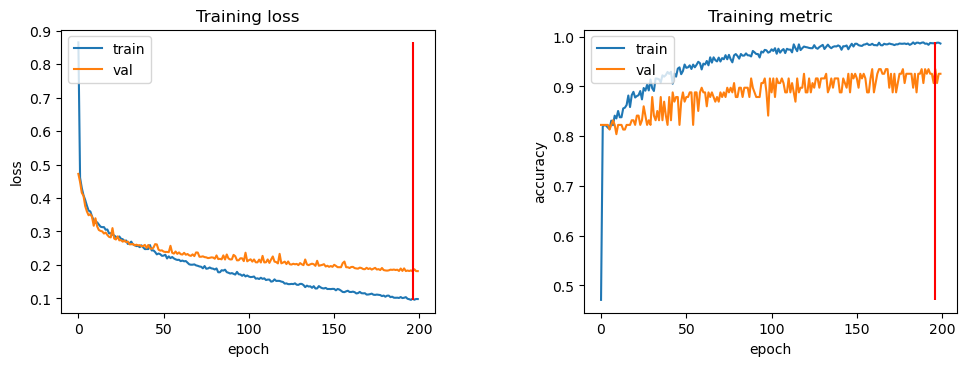

CPU times: total: 16h 39min 38s
Wall time: 2h 48min 1s


In [11]:
%%time
# train model A
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

optA = torch.optim.SGD(modelA.parameters(), lr=0.001)
loss_fnA = nn.CrossEntropyLoss()


epochs = 200

historyA, best_modelA, best_model_scoreA = train_save_best(model=modelA,
                                                            iterator=train_iter,
                                                            optimizer=optA,
                                                            criterion=loss_fnA,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)
torch.save(best_modelA, './Models/modelA')

In [ ]:
%%time
# train model B
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

optB = torch.optim.SGD(modelB.parameters(), lr=0.001)
loss_fnB = nn.CrossEntropyLoss()


epochs = 200

historyB, best_modelB, best_model_scoreB = train_save_best(model=modelB,
                                                            iterator=train_iter,
                                                            optimizer=optB,
                                                            criterion=loss_fnB,
                                                            epoch=epochs,
                                                            clip=1,
                                                            device=device)
torch.save(best_modelB, './Models/modelB')

  0%|          | 0/7 [00:00<?, ?it/s]C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu
100%|██████████| 7/7 [01:06<00:00,  9.56s/it]
C:\Users\jjung\AppData\Local\Temp\ipykernel_1684\317618357.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  src, trg = torch.tensor(src).to(device), torch.tensor(trg).to(device) # put to cpu/gpu


Epoch: 1  Train Loss: 0.5017               Validation Loss: 0.4421               Train acc: 0.8115,               Val acc: 0.8224


100%|██████████| 7/7 [00:53<00:00,  7.67s/it]


Epoch: 2  Train Loss: 0.4341               Validation Loss: 0.4048               Train acc: 0.8226,               Val acc: 0.8224


100%|██████████| 7/7 [00:53<00:00,  7.67s/it]


Epoch: 3  Train Loss: 0.4109               Validation Loss: 0.3817               Train acc: 0.8220,               Val acc: 0.8224


100%|██████████| 7/7 [00:53<00:00,  7.67s/it]


Epoch: 4  Train Loss: 0.3918               Validation Loss: 0.3681               Train acc: 0.8237,               Val acc: 0.8224


100%|██████████| 7/7 [00:53<00:00,  7.70s/it]


Epoch: 5  Train Loss: 0.3799               Validation Loss: 0.3511               Train acc: 0.8237,               Val acc: 0.8224


100%|██████████| 7/7 [00:53<00:00,  7.67s/it]


Epoch: 6  Train Loss: 0.3804               Validation Loss: 0.3396               Train acc: 0.8161,               Val acc: 0.8224


100%|██████████| 7/7 [00:46<00:00,  6.58s/it]


Epoch: 7  Train Loss: 0.3563               Validation Loss: 0.3500               Train acc: 0.8271,               Val acc: 0.8224


 29%|██▊       | 2/7 [00:14<00:35,  7.05s/it]

# Model fusion

### Definitions

In [ ]:
def weight_averaging(*weights):
  with torch.no_grad():
    sum = torch.zeros(weights[0].shape, device=device)
    for weight in weights:
      sum += weight
  return sum / len(weights)

In [ ]:
def linear_averaging(*linears):
  """Averages several linear layers (weights + biases)"""
  with torch.no_grad():
    weights = [linear.weight for linear in linears]
    biases = [linear.bias for linear in linears]

    linear_averaged = torch.nn.Linear(linears[0].in_features, linears[0].out_features, bias=True).to(device)
    linear_averaged.weight, linear_averaged.bias = torch.nn.Parameter(weight_averaging(*weights)), torch.nn.Parameter(weight_averaging(*biases))

  return linear_averaged

In [ ]:
def vanilla_fusion(modelA, modelB):
  # init
  model_fusion = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

  with torch.no_grad():
    # 1) encoder
    # TODO: smarter method for embedding
    # a) embedding
    weights_A = modelA.encoder.emb.tok_emb.weight
    weights_B = modelB.encoder.emb.tok_emb.weight

    weights_fusion = weight_averaging(weights_A, weights_B) # weights seem to be exactly the same?
    model_fusion.encoder.emb.tok_emb.weight = torch.nn.Parameter(weights_fusion)

    # b) encoder layers
    for i, _ in enumerate(modelA.encoder.layers):
      # i) self-attention (fuse Q, K, V separately) # TODO: check validity of this approach
      # query
      query_A = modelA.encoder.layers[i].attention.w_q
      query_B = modelB.encoder.layers[i].attention.w_q

      query_fusion = linear_averaging(query_A, query_B)
      model_fusion.encoder.layers[i].attention.w_q = query_fusion

      # key
      key_A = modelA.encoder.layers[i].attention.w_k
      key_B = modelB.encoder.layers[i].attention.w_k

      key_fusion = linear_averaging(key_A, key_B)
      model_fusion.encoder.layers[i].attention.w_k = key_fusion

      # value
      value_A = modelA.encoder.layers[i].attention.w_v
      value_B = modelB.encoder.layers[i].attention.w_v

      value_fusion = linear_averaging(value_A, value_B)
      model_fusion.encoder.layers[i].attention.w_v = value_fusion

      # output
      output_A = modelA.encoder.layers[i].attention.w_concat
      output_B = modelB.encoder.layers[i].attention.w_concat

      output_fusion = linear_averaging(output_A, output_B)
      model_fusion.encoder.layers[i].attention.w_concat = output_fusion

      # ii) layer norm 1
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

      # iii) feed-forward network
      # layer 1
      linear_A = modelA.encoder.layers[i].ffn.linear1
      linear_B = modelB.encoder.layers[i].ffn.linear1

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear1 = linear_fusion

      # layer 2
      linear_A = modelA.encoder.layers[i].ffn.linear2
      linear_B = modelB.encoder.layers[i].ffn.linear2

      linear_fusion = linear_averaging(linear_A, linear_B)
      model_fusion.encoder.layers[i].ffn.linear2 = linear_fusion

      # iv) layer norm 2
      # TODO: LAYER NORM WEIGHTS ARE NOT CALLABLE???

    # 2) MLP head
    linear_A = modelA.linear
    linear_B = modelB.linear

    linear_fusion = linear_averaging(linear_A, linear_B)
    model_fusion.linear = linear_fusion

  return model_fusion

In [ ]:
def test_fusion(modelA, modelB, model_fusion):
  # test fusion
  test_loss_A, test_acc_A = validation(modelA, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_B, test_acc_B = validation(modelB, test_iter, None, nn.CrossEntropyLoss(), device)
  test_loss_fusion, test_acc_fusion = validation(model_fusion, test_iter, None, nn.CrossEntropyLoss(), device)

  # visualize
  fig, ax = plt.subplots()

  metrics_A = [test_loss_A, test_acc_A]
  metrics_B = [test_loss_B, test_acc_B]
  metrics_fusion = [test_loss_fusion, test_acc_fusion]
  metrics = ['loss', 'accuracy']
  x = np.arange(len(metrics)) # positions of bars (1 per metric)
  width = 0.25  # the width of the bars

  rects1 = ax.bar(x - width, metrics_A, width, label='model A')
  rects2 = ax.bar(x, metrics_B, width, label='model B')
  rects3 = ax.bar(x + width, metrics_fusion, width, label='model fusion')

  ax.set_ylabel('Score')
  ax.set_title('Test metrics by models')
  ax.set_xticks(x)
  ax.set_xticklabels(metrics)
  ax.legend()

  plt.show()

### (Optional) load models

In [ ]:
# load parent models
# TODO: change enc_voc_size back
modelA = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)
modelB = TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device)

modelA.load_state_dict(torch.load('./Models/modelA'))
modelB.load_state_dict(torch.load('./Models/modelB'))

### Fusion

In [ ]:
model_fusion = vanilla_fusion(modelA, modelB)

### Test fusion

In [ ]:
# test with new randomly initialized transformer
test_fusion(modelA, modelB, TransformerClassifier(src_pad_idx = pad_idx,
                              enc_voc_size = voc_size,
                              max_len = 256,
                              d_model = 512,
                              ffn_hidden = 2048,
                              n_head = 1,
                              n_layers = 1,
                              drop_prob = 0.1,
                              device = device))

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)

### Retraining

In [ ]:
%%time
opt_fusion = torch.optim.SGD(model_fusion.parameters(), lr=0.001)
loss_fn_fusion = nn.CrossEntropyLoss()


epochs = 30
history_fusion, best_model_fusion, best_model_score_fusion = train_save_best(model=model_fusion,
                                                                             iterator=train_iter,
                                                                             optimizer=opt_fusion,
                                                                             criterion=loss_fn_fusion,
                                                                             epoch=epochs,
                                                                             clip=1,
                                                                             device=device)

In [ ]:
model_fusion.load_state_dict(best_model_fusion)

### Test fusion (after retraining)

In [ ]:
# test with vanilla fusion
test_fusion(modelA, modelB, model_fusion)